<a href="https://colab.research.google.com/github/nakanoelio/i2a2-challenge-petr4-trad-sys/blob/main/I2A2_PETR4_Multinomial_Naive_Bayes_Trading_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install --upgrade mplfinance
 
#Instalação da Biblioteca TA-lib
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install pandas_ta

Requirement already up-to-date: mplfinance in /usr/local/lib/python3.7/dist-packages (0.12.7a17)
(Reading database ... 160798 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sn
import matplotlib.pyplot as plt

import yfinance as yf

import talib as ta
import pandas_ta as pd_ta

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB

In [3]:
%matplotlib inline

In [4]:
stock_ticker = 'PETR4.SA'
start_date = '2016-01-26'
end_date = '2021-5-27'

yf_petr4 = yf.Ticker(stock_ticker)
df_petr4 = yf_petr4.history(start=start_date, end=end_date)

stock_ticker = '^BVSP'
yf_ibov = yf.Ticker(stock_ticker)
df_ibov = yf_ibov.history(start=start_date, end=end_date)

In [5]:
df_petr4.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-26,3.796411,3.868210,3.697686,3.769486,71933300,0.0,0
2016-01-27,3.787435,4.164384,3.733586,4.101560,79437900,0.0,0
2016-01-28,4.191310,4.604158,3.904111,4.128485,131960900,0.0,0
2016-01-29,4.218234,4.361834,4.056685,4.343884,93013900,0.0,0
2016-02-01,4.254133,4.361833,4.182333,4.236183,51910300,0.0,0
2016-02-02,4.092585,4.173360,3.859236,3.859236,53610300,0.0,0
2016-02-03,3.966934,4.056684,3.787435,4.029759,73786400,0.0,0
2016-02-04,4.092584,4.433633,3.913085,4.245159,91974200,0.0,0
2016-02-05,4.245158,4.290033,4.065659,4.074634,52704500,0.0,0


In [6]:
#Calculo dos Indicadores
def indicadores(stock_data):
    
    data = stock_data.copy()
    data['W%R'] = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14) #Retorna valor do indicador Williams %R
    data['MACD'], data['Signal-line'], data['Histograma_MACD'] = ta.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9) #Valores do indicador MACD
    data.loc[:, 'Momento_MACD']=np.where(data['Histograma_MACD']>0, 1, 0) #Retorna 1 para compra pelo MACD (momento positivo), 0 para venda
    data['Tendencia_MACD']=np.where(data['Histograma_MACD'].diff()>0, 1, 0) #Derivada, sinaliza reversao de tendencia no histograma MACD, 1 para compra, 0 para venda
    data.loc[:, 'W%R_Compra']= np.where(data['W%R']<-80, 1, 0) # Retorna 1 para sinal de compra, caso Williams %R < -80
    data.loc[:, 'W%R_Venda']= np.where(data['W%R']>-20, 1, 0)  # Retorna 1 para sinal de venda, caso Williams %R > -20
    
    data['Hammer']=ta.CDLHAMMER(data['Open'],data['High'], data['Low'], data['Close'])/100 #Sinal de compra pra martelo
    data['Shooting_star'] = ta.CDLSHOOTINGSTAR(data['Open'],data['High'], data['Low'], data['Close'])/-100 #Sinal de venda 'estrela cadente'
    data["EMA12"] =  ta.EMA(data["Close"], timeperiod=12)
    data["EMA26"] =  ta.EMA(data["Close"], timeperiod=26)

    
    #return data.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits"],axis="columns")
    return data[['Momento_MACD','Tendencia_MACD','W%R_Compra','W%R_Venda']]#,"EMA12","EMA26",'W%R','MACD','Hammer','Shooting_star','Momento_MACD','Tendencia_MACD','W%R_Compra','W%R_Venda']]

In [7]:
def isSupport(df,i):
    #Estamos utilizando dados futuros!
    #support = df['Low'][i] <= df['Low'][i-1]  and df['Low'][i] <= df['Low'][i+1] and df['Low'][i] < df['Low'][i+2] and df['Low'][i] < df['Low'][i-2]
    #support = df['Low'][i-1] <= df['Low'][i-3]  and df['Low'][i-2] <= df['Low'][i-1] and df['Low'][i-2] < df['Low'][i] and df['Low'][i-2] < df['Low'][i-4]
    support = df['Low'][i] <= df['Low'][i-2]  and df['Low'][i-1] <= df['Low'][i-2] and np.abs(df['Low'][i]-df['Low'][i-1]) < np.abs(df['Low'][i-1]-df['Low'][i-2])
    
    return support

def isResistance(df,i):
    #Estamos utilizando dados futuros!
    #resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i] > df['High'][i+2] and df['High'][i] > df['High'][i-2]
    #resistance = df['High'][i-2] > df['High'][i-3]  and df['High'][i-2] > df['High'][i-1] and df['High'][i-2] > df['High'][i] and df['High'][i-2] > df['High'][i-4]
    resistance = df['High'][i] > df['High'][i-2]  and df['High'][i-1] > df['High'][i-2] and np.abs(df['High'][i]-df['High'][i-1]) < np.abs(df['High'][i-1]-df['High'][i-2])
    
    return resistance 

In [8]:
def sup_res(df_data):
    s =  np.mean(df_data['High'] - df_data['Low'])
    levels = []
    support = [0,0]
    resistance = [0,0]
    for i in range(2,df_data.shape[0]-2):
        if isSupport(df_data,i):
            l = df_data['Low'][i]
            support.append(1)
            resistance.append(0)
            levels.append((i,l))
            #if isFarFromLevel(l,levels,s):
                #support.append(1)
                #resistance.append(0)
                #levels.append((i,l))
            #else:
                #support.append(0)
                #resistance.append(0)
        elif isResistance(df_data,i):
            l = df_data['High'][i]
            support.append(0)
            resistance.append(1)
            #if isFarFromLevel(l,levels,s):
                #resistance.append(1)
                #support.append(0)
                #levels.append((i,l))
            #else:
                #resistance.append(0)
                #support.append(0)
        else:
            resistance.append(0)
            support.append(0)
    support.extend([0,0])
    resistance.extend([0,0])

    return support, resistance

In [9]:
def feat_gen(data_f, p_window,return_period):
    
    data_frame = data_f.copy()

    #data_frame["Close_Return"] = data_frame["Close"].diff()
    data_frame["Close_Return_Rel"] = data_frame["Close"].pct_change()
    
    #data_frame["Close_Return"].fillna(0,inplace=True)
    #data_frame["Close_Return_Rel"].fillna(0,inplace=True)
    tresh = data_frame["Close_Return_Rel"].std()*0.05*return_period
    #tresh = 0
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() > tresh, "Expected_Close_Return"] = 3
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() <= tresh, "Expected_Close_Return"] = 2
    data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < -tresh, "Expected_Close_Return"] = 1
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() >= tresh, f"Expected_Close_Return"] = 1
    #data_frame.loc[data_frame["Close_Return_Rel"].rolling(return_period).sum() < tresh, f"Expected_Close_Return"] = 0
   
    #new_col_names = []
 
    for i in range(0,p_window):
    
        data_frame[f'Return_Lag_{i}period'] = data_frame["Close_Return_Rel"].shift(periods=i).apply(lambda x: 2 if x > tresh else (1 if x <- tresh else 0))
        #data_frame[f'Return_Lag_{i}period'] = data_frame["Close_Return_Rel"].rolling(i+1).sum()
    
    data_frame["Expected_Close_Return"] = data_frame["Expected_Close_Return"].shift(-return_period)
    

    return data_frame.drop(["Open","Close","High","Low","Volume","Dividends","Stock Splits","Close_Return_Rel"],axis="columns").fillna(0)
    #return data_frame[["Expected_Close_Return"].fillna(0)

In [10]:
def calc_beta(data_frame_asset,data_frame_bench, beta_window):
    data_frame_beta = pd.concat([data_frame_bench["Close"].pct_change(), data_frame_asset["Close"].pct_change()],axis=1,ignore_index=True)

    data_frame_beta.columns=["Close_IBOV","Close_PETR4"]

    data_frame_beta["Beta"] = data_frame_beta["Close_PETR4"].rolling(beta_window).cov(data_frame_beta["Close_IBOV"].rolling(beta_window))/data_frame_beta["Close_IBOV"].rolling(beta_window).var()

    data_frame_beta["Beta_expected_PETR4"] = data_frame_beta["Close_IBOV"]*data_frame_beta["Beta"]

    data_frame_beta["PETR4_Excess_Variat"] = (data_frame_beta["Close_PETR4"] - data_frame_beta["Beta_expected_PETR4"])#/data_frame_beta["Beta_expected_PETR4"]
    #data_frame_beta["PETR4_Excess_Variat"].describe()
    var_tolerance = 1#data_frame_beta["Close_IBOV"].std()#/data_frame_beta["Close_IBOV"].mean()

    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  > var_tolerance, "PETR4_Excess_Variat_Disc"] = 1
    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"] <= var_tolerance , "PETR4_Excess_Variat_Disc"] = 0
    data_frame_beta.loc[data_frame_beta["PETR4_Excess_Variat"]  < -var_tolerance, "PETR4_Excess_Variat_Disc"] = 1
    

    #return data_frame_beta.drop(["Close_IBOV","Close_PETR4",], axis="columns").fillna(0)
    
    #return data_frame_beta["PETR4_Excess_Variat_Disc"].fillna(0)
    return data_frame_beta["PETR4_Excess_Variat_Disc"].fillna(0)

In [11]:
def gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window):

    #df_feat = data_frame_orig
    df_feat = pd.concat([data_frame_orig, feat_gen(data_frame_orig, p_window, return_period)],axis=1)
    df_feat = pd.concat([df_feat,indicadores(data_frame_orig)],axis=1)
    #sup,res = sup_res(data_frame_orig)
    #df_feat["Support"] = sup
    #df_feat["Resistance"] = res
    df_feat = pd.concat([df_feat,calc_beta(data_frame_orig,data_frame_bench,beta_window)],axis=1)
    df_feat = df_feat.reindex(columns=(list([col for col in df_feat.columns if col != "Expected_Close_Return"]+["Expected_Close_Return"])))
    df_feat = df_feat.drop(["Stock Splits","Dividends","Volume",'Open','High','Low'],axis=1)#"Close"

    return df_feat

In [12]:
def train_eval(df,train_init_date,train_end_date):#,test_end_date):
   
    dia_ini_train_idx = df.index.get_loc(train_init_date)
    dia_fin_train_idx = df.index.get_loc(train_end_date)
    #dia_fin_test_idx = df.index.get_loc(test_end_date)
    y_label_idx = df.columns.get_loc("Expected_Close_Return")
    X_tr = df.iloc[dia_ini_train_idx:dia_fin_train_idx].drop('Expected_Close_Return',axis='columns')
    X_ts = df.iloc[dia_fin_train_idx].drop('Expected_Close_Return')#,axis='columns')
    #print(X_ts)
    y_tr = df.iloc[dia_ini_train_idx:dia_fin_train_idx,y_label_idx]
    y_ts = df.iloc[dia_fin_train_idx,y_label_idx]

    return X_tr, X_ts, y_tr, y_ts

In [34]:
def run_model(X,y,model_type):
        
    nb_model = model_type
    nb_model.fit(X, y)

    
    
    #np.column_stack((y_test.to_list(),nb_model.predict(X_test)))
    #print(nb_model.predict_proba(X_test)[:10])
    #print(f'test_score = {nb_model.score(X_test,y_test)}')

    return nb_model

def meas_acc(X,y,nb_model):
    y_pred = nb_model.predict(X)
    print("Number of mislabeled points out of a total %d points : %d" % (X.shape[0], (y != y_pred).sum()))
    print("Train Accuracy: %f"% metrics.balanced_accuracy_score(y, y_pred))
    cf_train2 = metrics.confusion_matrix(y, y_pred, normalize="all")                                  
    sn.heatmap(cf_train2,linewidths=.5,annot=True,cmap="YlGnBu",cbar=False,square=True,xticklabels=(1,2,3), yticklabels=(1,2,3))
   

In [91]:
data_frame_orig = df_petr4
p_window = 90
beta_window = 30
data_frame_bench = df_ibov

return_period = 1
df_petr4_1 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

return_period = 2
df_petr4_2 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

return_period = 3
df_petr4_3 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

return_period = 5
df_petr4_5 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

return_period = 10
df_petr4_10 = gen_feat_data(data_frame_orig,p_window,return_period,data_frame_bench,beta_window).fillna(0)

In [15]:
df_petr4_1

,Close,Return_Lag_0period,Return_Lag_1period,Return_Lag_2period,Return_Lag_3period,Return_Lag_4period,Return_Lag_5period,Return_Lag_6period,Return_Lag_7period,Return_Lag_8period,Return_Lag_9period,Return_Lag_10period,Return_Lag_11period,Return_Lag_12period,Return_Lag_13period,Return_Lag_14period,Return_Lag_15period,Return_Lag_16period,Return_Lag_17period,Return_Lag_18period,Return_Lag_19period,Return_Lag_20period,Return_Lag_21period,Return_Lag_22period,Return_Lag_23period,Return_Lag_24period,Return_Lag_25period,Return_Lag_26period,Return_Lag_27period,Return_Lag_28period,Return_Lag_29period,Return_Lag_30period,Return_Lag_31period,Return_Lag_32period,Return_Lag_33period,Return_Lag_34period,Return_Lag_35period,Return_Lag_36period,Return_Lag_37period,Return_Lag_38period,...,Return_Lag_156period,Return_Lag_157period,Return_Lag_158period,Return_Lag_159period,Return_Lag_160period,Return_Lag_161period,Return_Lag_162period,Return_Lag_163period,Return_Lag_164period,Return_Lag_165period,Return_Lag_166period,Return_Lag_167period,Return_Lag_168period,Return_Lag_169period,Return_Lag_170period,Return_Lag_171period,Return_Lag_172period,Return_Lag_173period,Return_Lag_174period,Return_Lag_175period,Return_Lag_176period,Return_Lag_177period,Return_Lag_178period,Return_Lag_179period,Return_Lag_180period,Return_Lag_181period,Return_Lag_182period,Return_Lag_183period,Return_Lag_184period,Return_Lag_185period,Return_Lag_186period,Return_Lag_187period,Return_Lag_188period,Return_Lag_189period,Momento_MACD,Tendencia_MACD,W%R_Compra,W%R_Venda,PETR4_Excess_Variat_Disc,Expected_Close_Return
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-26,3.769486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0
2016-01-27,4.101560,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0
2016-01-28,4.128485,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,3.0
2016-01-29,4.343884,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0
2016-02-01,4.236183,1,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-20,25.930000,1,1,1,2,2,2,1,2,2,2,1,2,1,1,0,1,2,1,2,0,1,1,2,1,1,2,2,2,1,1,0,0,2,1,2,0,2,2,2,...,1,2,1,1,1,1,2,2,0,1,1,1,2,1,2,2,1,2,1,2,1,1,1,2,1,1,1,2,1,1,1,2,1,2,1,0,0,0,0.0,2.0
2021-05-21,25.950001,0,1,1,1,2,2,2,1,2,2,2,1,2,1,1,0,1,2,1,2,0,1,1,2,1,1,2,2,2,1,1,0,0,2,1,2,0,2,2,...,1,1,2,1,1,1,1,2,2,0,1,1,1,2,1,2,2,1,2,1,2,1,1,1,2,1,1,1,2,1,1,1,2,1,1,0,0,0,0.0,3.0
2021-05-24,26.389999,2,0,1,1,1,2,2,2,1,2,2,2,1,2,1,1,0,1,2,1,2,0,1,1,2,1,1,2,2,2,1,1,0,0,2,1,2,0,2,...,1,1,1,2,1,1,1,1,2,2,0,1,1,1,2,1,2,2,1,2,1,2,1,1,1,2,1,1,1,2,1,1,1,2,1,0,0,1,0.0,1.0


Number of mislabeled points out of a total 506 points : 200
Train Accuracy: 0.448091


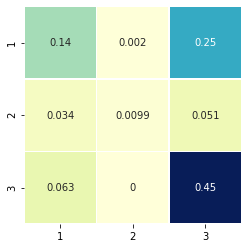

In [92]:
X,_,y,_ = train_eval(df_petr4_1,"2016-01-26 00:00:00","2018-01-26 00:00:00")
gnb1 = run_model(X,y, MultinomialNB())
meas_acc(X,y,gnb1)

Number of mislabeled points out of a total 506 points : 200
Train Accuracy: 0.454138


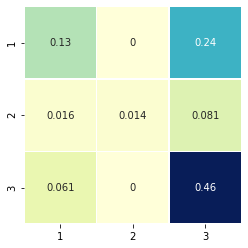

In [93]:
X,_,y,_ = train_eval(df_petr4_2,"2016-01-26 00:00:00","2018-01-26 00:00:00")
gnb2 = run_model(X,y, MultinomialNB())
meas_acc(X,y,gnb2)

Number of mislabeled points out of a total 506 points : 198
Train Accuracy: 0.443904


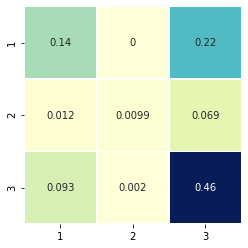

In [94]:
X,_,y,_ = train_eval(df_petr4_3,"2016-01-26 00:00:00","2018-01-26 00:00:00")
gnb3 = run_model(X,y, MultinomialNB())
meas_acc(X,y,gnb3)

Number of mislabeled points out of a total 506 points : 184
Train Accuracy: 0.507364


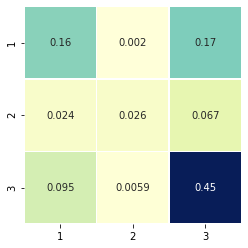

In [95]:
X,_,y,_ = train_eval(df_petr4_5,"2016-01-26 00:00:00","2018-01-26 00:00:00")
gnb5 = run_model(X,y, MultinomialNB())
meas_acc(X,y,gnb5)

Number of mislabeled points out of a total 506 points : 158
Train Accuracy: 0.584099


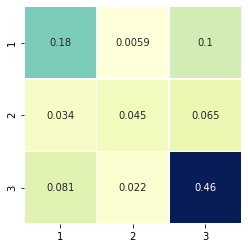

In [96]:
X,_,y,_ = train_eval(df_petr4_10,"2016-01-26 00:00:00","2018-01-26 00:00:00")
gnb10 = run_model(X,y, MultinomialNB())
meas_acc(X,y,gnb10)

In [35]:
def rolling_results(df,dia_ini_train_idx,dia_ini_test_idx,model):
    results = []
    for i in df.iloc[dia_ini_train_idx:dia_ini_test_idx].index:
        X,X_test,y,y_test = train_eval(df,"2016-01-26 00:00:00",i)
        nb_model = run_model(X,y,model)
        y_predict = nb_model.predict(X_test.to_numpy().reshape(1, -1)).item()
        y_predictX = nb_model.predict(X)
        y_prob = nb_model.predict_proba(X_test.to_numpy().reshape(1, -1))
        acc = metrics.balanced_accuracy_score(y, y_predictX) 
        results.append([i,y_test,y_predict]+list(y_prob[0])+[acc])
        
    return results, nb_model

In [22]:
dia_ini_test_idx = df_petr4_1.index.get_loc("2018-01-26 00:00:00")
dia_end_test_idx = df_petr4_1.index.get_loc("2021-05-26 00:00:00")

In [97]:
res1,_ = rolling_results(df_petr4_1,dia_ini_test_idx,dia_end_test_idx,BernoulliNB())
res2,_ = rolling_results(df_petr4_2,dia_ini_test_idx,dia_end_test_idx,BernoulliNB())
res3,_ = rolling_results(df_petr4_2,dia_ini_test_idx,dia_end_test_idx,BernoulliNB())
res5,_ = rolling_results(df_petr4_5,dia_ini_test_idx,dia_end_test_idx,BernoulliNB())
res10,_ = rolling_results(df_petr4_10,dia_ini_test_idx,dia_end_test_idx,BernoulliNB())
print(res1)
print(res2)
print(res5)
print(res10)

[[Timestamp('2018-01-26 00:00:00'), 1.0, 3.0, 0.3333519509279455, 0.004110507029364722, 0.6625375420426922, 0.4830710910318326], [Timestamp('2018-01-29 00:00:00'), 1.0, 3.0, 0.27595311689473057, 0.01563965000411173, 0.7084072331011604, 0.482998798775526], [Timestamp('2018-01-30 00:00:00'), 3.0, 3.0, 0.2535003235596886, 0.013905640852765726, 0.7325940355875465, 0.4829143855861413], [Timestamp('2018-01-31 00:00:00'), 3.0, 3.0, 0.40429100647627364, 0.009788588548431232, 0.5859204049752974, 0.48367387435828507], [Timestamp('2018-02-01 00:00:00'), 1.0, 3.0, 0.431075512138775, 0.08925576936242924, 0.47966871849879433, 0.48442760942760943], [Timestamp('2018-02-02 00:00:00'), 1.0, 1.0, 0.5106557667568004, 0.04297783692870664, 0.4463663963144926, 0.48560352266382417], [Timestamp('2018-02-05 00:00:00'), 3.0, 3.0, 0.3961721396627761, 0.00033090017794669814, 0.6034969601592748, 0.48803030303030304], [Timestamp('2018-02-06 00:00:00'), 1.0, 1.0, 0.5517589907555516, 0.001725051538362054, 0.4465159577

In [82]:
import statistics
trade_instruction = []
for i in range(len(res1)):
    #vend = res1[i][3]#*res2[i][3]#*res3[i][3]*res5[i][3]*res10[i][3]
    #mant = res1[i][4]#*res2[i][4]#*res3[i][4]*res5[i][4]*res10[i][4]
    #comp = res1[i][5]#*res2[i][5]#*res3[i][5]*res5[i][5]*res10[i][5]
    criterion_1 = [1 if res1[i][3]>res1[i][4]+res1[i][5] else (3 if res1[i][3]+res1[i][4]<res1[i][5] else 2)]
    criterion_2 = [1 if res2[i][3]>res2[i][4]+res2[i][5] else (3 if res2[i][3]+res2[i][4]<res2[i][5] else 2)]
    criterion_3 = [1 if res3[i][3]>res3[i][4]+res3[i][5] else (3 if res3[i][3]+res3[i][4]<res3[i][5] else 2)]
    criterion_5 = [1 if res5[i][3]>res5[i][4]+res5[i][5] else (3 if res5[i][3]+res5[i][4]<res5[i][5] else 2)]
    criterion_10 = [1 if res10[i][3]>res10[i][4]+res10[i][5] else (3 if res10[i][3]+res10[i][4]<res10[i][5] else 2)]
    #print(res1[i][6],res2[i][6],res3[i][6],res5[i][6],res10[i][6])
    criteria = [criterion_1, criterion_2, criterion_3, criterion_5, criterion_10]
    criteria_acc = [res1[i][6],res2[i][6],res3[i][6],res5[i][6],res10[i][6]]
    max_acc = max(criteria_acc)
    max_index = criteria_acc.index(max_acc)
    max_acc_criteria = criteria[max_index]
    media = max_acc_criteria[0]
    #media = sp.stats.mode(criteria_10)[0][0]
    #media = 1 if vend>mant+comp else (3 if vend+mant<comp else 2)
    #print(media)
    if media>2:
        trade_instruction.append([res1[i][0],"C"])
    elif media==2:
        trade_instruction.append([res1[i][0],"_"])
    elif media<2:
        trade_instruction.append([res1[i][0],"V"])
print(trade_instruction)

[[Timestamp('2018-01-26 00:00:00'), '_'], [Timestamp('2018-01-29 00:00:00'), '_'], [Timestamp('2018-01-30 00:00:00'), '_'], [Timestamp('2018-01-31 00:00:00'), '_'], [Timestamp('2018-02-01 00:00:00'), '_'], [Timestamp('2018-02-02 00:00:00'), '_'], [Timestamp('2018-02-05 00:00:00'), '_'], [Timestamp('2018-02-06 00:00:00'), '_'], [Timestamp('2018-02-07 00:00:00'), '_'], [Timestamp('2018-02-08 00:00:00'), '_'], [Timestamp('2018-02-09 00:00:00'), '_'], [Timestamp('2018-02-15 00:00:00'), '_'], [Timestamp('2018-02-16 00:00:00'), '_'], [Timestamp('2018-02-19 00:00:00'), 'C'], [Timestamp('2018-02-20 00:00:00'), 'C'], [Timestamp('2018-02-21 00:00:00'), 'C'], [Timestamp('2018-02-22 00:00:00'), 'C'], [Timestamp('2018-02-23 00:00:00'), 'C'], [Timestamp('2018-02-26 00:00:00'), 'C'], [Timestamp('2018-02-27 00:00:00'), 'C'], [Timestamp('2018-02-28 00:00:00'), 'C'], [Timestamp('2018-03-01 00:00:00'), 'C'], [Timestamp('2018-03-02 00:00:00'), 'C'], [Timestamp('2018-03-05 00:00:00'), '_'], [Timestamp('201

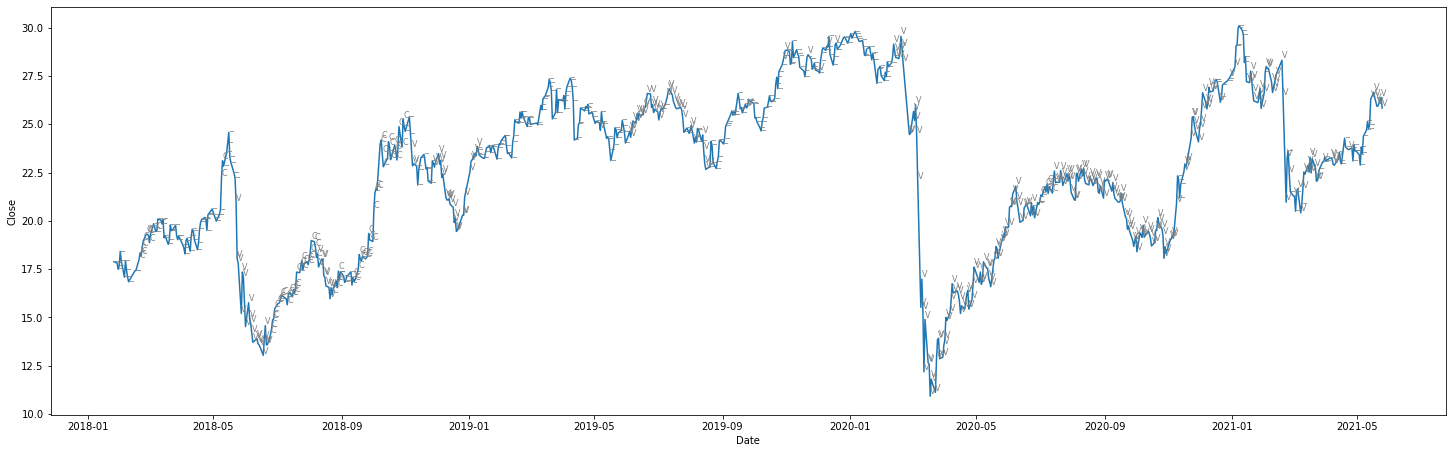

In [83]:
fig, ax = plt.subplots(figsize=(25, 7.5))
sn.lineplot(data=df_petr4["Close"].iloc[dia_ini_test_idx:dia_end_test_idx],ax=ax)
style = dict(size=8, color='gray')
for i in range(len(trade_instruction)):
    ax.text(trade_instruction[i][0], df_petr4["Close"].iloc[dia_ini_test_idx:dia_end_test_idx].iloc[i]+.1, trade_instruction[i][1],**style)

In [84]:
stock = 100
cash = 0
for i in range(len(trade_instruction)):
    Total_Value_Init = 100*df_petr4_1["Close"].loc[trade_instruction[0][0]]
    if cash <=0 and stock <=0:
        print(i,stock,cash)
        break
    elif trade_instruction[i][1] == "C":
        if cash > 0:
            stock += (cash/2)/df_petr4_1["Close"].loc[trade_instruction[i][0]]
            cash = cash/2
            print(i,stock,cash,"c",df_petr4_1["Close"].loc[trade_instruction[i][0]],trade_instruction[i][0])
        elif cash == 0 and stock > 0:
            
            pass
        elif cash <=0 and stock <=0:
            
            break
        print(i,stock,cash,"c",df_petr4_1["Close"].loc[trade_instruction[i][0]],trade_instruction[i][0])
    elif trade_instruction[i][1] == "M":
        print(i,stock,cash,"m",df_petr4_1["Close"].loc[trade_instruction[i][0]],trade_instruction[i][0])
        pass
    elif trade_instruction[i][1] == "V":
        if stock > 0:
            cash += (stock*.75)*df_petr4_1["Close"].loc[trade_instruction[i][0]]
            stock = 0.25*stock
            print(i,stock,cash,"v",df_petr4_1["Close"].loc[trade_instruction[i][0]],trade_instruction[i][0])
        elif cash > 0 and stock == 0:
            
            pass
        elif cash <=0 and stock <=0:
            
            break        
        print(i,stock,cash,"v",df_petr4_1["Close"].loc[trade_instruction[i][0]],trade_instruction[i][0])
    a = df_petr4_1["Close"].loc[trade_instruction[i][0]]
    print(a)
    print(Total_Value_Init)
    b = i
    print(f"dias negociados: {b}, qtd_ações: {stock}, dinheiro: R$ {cash}, Total Value: R$ {cash+stock*a}, Lucro: R$ {(cash+stock*a)-Total_Value_Init}")



17.887107849121094
1788.7107849121094
dias negociados: 0, qtd_ações: 100, dinheiro: R$ 0, Total Value: R$ 1788.7107849121094, Lucro: R$ 0.0
17.8153076171875
1788.7107849121094
dias negociados: 1, qtd_ações: 100, dinheiro: R$ 0, Total Value: R$ 1781.53076171875, Lucro: R$ -7.180023193359375
17.49220848083496
1788.7107849121094
dias negociados: 2, qtd_ações: 100, dinheiro: R$ 0, Total Value: R$ 1749.220848083496, Lucro: R$ -39.48993682861328
17.680683135986328
1788.7107849121094
dias negociados: 3, qtd_ações: 100, dinheiro: R$ 0, Total Value: R$ 1768.0683135986328, Lucro: R$ -20.642471313476562
18.416627883911133
1788.7107849121094
dias negociados: 4, qtd_ações: 100, dinheiro: R$ 0, Total Value: R$ 1841.6627883911133, Lucro: R$ 52.952003479003906
17.923006057739258
1788.7107849121094
dias negociados: 5, qtd_ações: 100, dinheiro: R$ 0, Total Value: R$ 1792.3006057739258, Lucro: R$ 3.5898208618164062
17.088333129882812
1788.7107849121094
dias negociados: 6, qtd_ações: 100, dinheiro: R$ 0, 